In [23]:
#!/usr/bin/env python3
"""experiment_viterbi.ipynb
James Gardner 2019
ANU / Melbourne Uni

applies viterbi analysis pipeline to experiment video of
michelson interferometer with a mirror driven at a changing frequency
takes signal as time series of intensity at the video's centre
"""

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook as tqdm
import scipy.io.wavfile as wavfile

In [24]:
def viterbi_pathfinder(grid, scanning_range=3):
    """find the highest scoring path through the grid, left-to-right,
    as by the viterbi algorithm, with connections plus-minus the scanning_range;
    returns score grid for best path to each node and a bitmap of the total best path
    """
    # normalised grid, algorithm goal is to maximise product of values
    ngrid  = grid/np.max(grid)
    # logarithm avoids underflow, equvivalent to maximise sum of log of values
    lngrid = np.log(ngrid)
    
    long_timesteps = grid.shape[1]

    # keep track of running scores for best path to each node
    score_grid  = np.copy(lngrid)
    pathfinder_flag = len(lngrid[:,0])
    # pathfinder stores the survivor paths, i.e. the previous best step
    # to allow back-tracking to recover the best total path at the end
    pathfinder = np.full(np.shape(lngrid), pathfinder_flag)
    # pathfinder flag+1 for reaching the first, 0-index column        
    pathfinder[:,0] = pathfinder_flag+1       

    # implementation of the viterbi algorithm itself
    # finding the best path to each node, through time
    # see: https://www.youtube.com/watch?v=6JVqutwtzmo
    for j in range(1,long_timesteps):
        for i in range(len(score_grid[:,j])):
            # index values for where to look relative to i in previous column
            k_a = max(0, i-scanning_range) 
            k_b = min(len(score_grid[:,j-1])-1,
                      i+scanning_range)
            window = score_grid[:,j-1][k_a:k_b+1]
            # find the best thing nearby in the previous column ...
            window_score = np.max(window)
            window_ref   = k_a+np.argmax(window)
            # ... and take note of it, summing the log of values
            score_grid[i][j] += window_score
            pathfinder[i][j] = window_ref 

    # look at the very last column, and find the best total ending ...
    best_score  = np.max(score_grid[:,-1])
    best_end = np.argmax(score_grid[:,-1])
    # ... and retrace its steps through the grid
    best_path_back = np.full(long_timesteps,pathfinder_flag+2)
    best_path_back[-1] = best_end
    # best_path_back is the viterbi path, the highest scoring overall 
    # path_grid is the binary image of the viterbi path taken
    path_grid = np.zeros(np.shape(ngrid))
    tmp_path = pathfinder[best_end][-1]

    for j in reversed(range(0,long_timesteps-1)):
        path_grid[tmp_path][j] = 1
        # take pathfinder value in current step and follow it backwards
        best_path_back[j] = tmp_path    
        tmp_path = pathfinder[tmp_path][j]

    # make sure we got all the way home
    # (that the retrace found the initial edge)
    assert tmp_path == pathfinder_flag+1
    
    return score_grid, path_grid

In [25]:
def fourier_spectrum(signal, fps, return_spectrum=False,
                     produce_plot=False, out_plot_name='tmp.pdf', out_plot_title=''):
    """finds fourier spectrum of signal time series as numpy array,
    has functionality to return and/or plot the sectrum (both default off),
    built from code originally found in tracker_time_series.ipynb
    """   
    signal_frames = len(signal)
    # will drop two frames later, fps: frames per second
    total_time = (signal_frames-2)/fps
    t = np.linspace(0,total_time,signal_frames)
    dt = t[1] - t[0]

    yf = np.fft.fft(signal)
    # normalised-absolute value of FT'd signal
    nrm_abs_yf = 2/signal_frames*np.abs(yf)
    # values at the centre of each frequency bin
    freq_scale = np.fft.fftfreq(len(yf),dt)
    # real signals are symmetric about 0 in frequency domain
    freq_scale_positive = freq_scale[:signal_frames//2]
    # frequency distribution values on positive side
    freq_prob = nrm_abs_yf[:signal_frames//2]
    
    if produce_plot:
        fig, (ax0,ax1) = plt.subplots(2,figsize=(14,14))
        ax0.plot(t,signal)
        ax0.set(title='signal: {}'.format(out_plot_title),ylabel='signal strength',xlabel='time, t')
        # signal average value gives magnitude of frequency = 0 term
        # simple fix is to drop first two bins, otherwise need to shift signal
        ax1.plot(freq_scale_positive[2:],freq_prob[2:])
        ax1.set(title='discrete FFT',ylabel='freq strength in signal',xlabel='frequency, f')
        plt.savefig(out_plot_name,bbox_inches='tight')
        plt.clf()
    
    if return_spectrum:
        return freq_prob[2:], freq_scale_positive[2:]        

In [26]:
def fourier_spectrum_2(signal, fps, return_spectrum=False,
                     produce_plot=False, out_plot_name='tmp.pdf', out_plot_title='',
                      cutter=None, remove_mains=False):
    """finds fourier spectrum of signal time series as numpy array,
    has functionality to return and/or plot the sectrum (both default off),
    built from code originally found in tracker_time_series.ipynb
    """   
    signal_frames = len(signal)
    if cutter is None:
        cutter = 0
    
    # will drop two frames later, fps: frames per second
    total_time = (signal_frames-cutter)/fps
    t = np.linspace(0,total_time,signal_frames)
    dt = t[1] - t[0]

    yf = np.fft.fft(signal)
    # normalised-absolute value of FT'd signal
    nrm_abs_yf = 2/signal_frames*np.abs(yf)
    # values at the centre of each frequency bin
    freq_scale = np.fft.fftfreq(len(yf),dt)
    # real signals are symmetric about 0 in frequency domain
    freq_scale_positive = freq_scale[cutter:signal_frames//2]
    # frequency distribution values on positive side
    freq_prob = nrm_abs_yf[cutter:signal_frames//2]
    
    # freqscale 0, +inf, -inf, -0
    #print(freq_scale[:10], freq_prob[:10])#,freq_scale[-5])
    
    if produce_plot:
        
        # tune out 50Hz mains noise
        # closest value in scale is index 5
        #to_go = None#(5,)#tuple(range(10))#(5,)
        # mains_mark
        to_go = ()
        
        if remove_mains:
            mm_0, mm_1 = None, None
            for i, f in enumerate(freq_scale_positive):
                if f > 50:
                    mm_0, mm_1 = i-1, i
                    break
            mm_f_0 = freq_scale_positive[mm_0]
            mm_f_1 = freq_scale_positive[mm_1]
            if abs(mm_f_0-50) < abs(mm_f_1-50):
                to_go = (mm_0,)
            else:
                to_go = (mm_1,)
            
        #print(to_go)
        to_go = tuple(to_go[0]+i for i in (-1,0,1))
        
        freq_prob_mained = np.delete(freq_prob, to_go)
        freq_scale_positive_mained = np.delete(freq_scale_positive, to_go)        
        
        #print(np.abs(yf)[:7])
        to_go_pandn = to_go + tuple(len(yf)-i for i in to_go)
        #print(to_go_pandn)
        
        yf_mained = np.delete(yf, to_go_pandn)
        t_mained = np.delete(t, to_go_pandn)
        iyfm = np.fft.ifft(yf_mained)
        
        fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(21,14))
        ax0,ax1,ax2,ax3 = axes[0,0],axes[1,0],axes[0,1],axes[1,1]
        ax0.plot(t, signal)
        ax0.set(title='signal: {}'.format(out_plot_title),ylabel='signal strength',xlabel='time, t')
        ax2.plot(t_mained,iyfm)
        ax2.set(title='i mained signal: {}'.format(out_plot_title),ylabel='signal strength',xlabel='time, t')
        # signal average value gives magnitude of frequency = 0 term
        # simple fix is to drop first two bins, otherwise need to shift signal
        ax1.plot(freq_scale_positive,freq_prob)
        ax1.set(title='discrete FFT',ylabel='freq strength in signal',xlabel='frequency, f')        
        ax3.plot(freq_scale_positive_mained,freq_prob_mained)
        ax3.set(title='mained discrete FFT',ylabel='freq strength in signal',xlabel='frequency, f')
        plt.savefig(out_plot_name,bbox_inches='tight')
        plt.clf()
    
    if return_spectrum:
        return freq_prob, freq_scale_positive  

In [27]:
def cut_mains(signal, fps, cutter=1):
    signal_frames = len(signal)
    
    total_time = (signal_frames-cutter)/fps
    t = np.linspace(0,total_time,signal_frames)
    dt = t[1] - t[0]

    yf = np.fft.fft(signal)
    # normalised-absolute value of FT'd signal
    nrm_abs_yf = 2/signal_frames*np.abs(yf)
    # values at the centre of each frequency bin
    freq_scale = np.fft.fftfreq(len(yf),dt)
    # real signals are symmetric about 0 in frequency domain
    freq_scale_positive = freq_scale[cutter:signal_frames//2]
    # frequency distribution values on positive side
    freq_prob = nrm_abs_yf[cutter:signal_frames//2]

    # tune out 50Hz mains noise
    to_go = ()
    mm_0, mm_1 = None, None
    for i, f in enumerate(freq_scale_positive):
        if f > 50:
            mm_0, mm_1 = i-1, i
            break
    mm_f_0 = freq_scale_positive[mm_0]
    mm_f_1 = freq_scale_positive[mm_1]
    if abs(mm_f_0-50) < abs(mm_f_1-50):
        to_go = (mm_0,)
    else:
        to_go = (mm_1,)

    #print(to_go)
    to_go = tuple(to_go[0]+i for i in (-1,0,1))

    freq_prob_mained = np.delete(freq_prob, to_go)
    freq_scale_positive_mained = np.delete(freq_scale_positive, to_go)        

    #print(np.abs(yf)[:7])
    to_go_pandn = to_go + tuple(len(yf)-i for i in to_go)
    #print(to_go_pandn)

    yf_mained = np.delete(yf, to_go_pandn)
    t_mained = np.delete(t, to_go_pandn)
    iyfm = np.fft.ifft(yf_mained)

    return np.abs(iyfm), t_mained

In [28]:
def absmax(axis):
    return max(abs(np.min(axis)), abs(np.max(axis)))

In [129]:
filename = 'podo_opera3.csv'
# https://samplefocus.com/samples/sisters-voices
# https://www.soundsnap.com/tags/opera
# out_file_name = 'feynman_cut.wav'
mega = np.genfromtxt(filename,delimiter=',')

long_signal = mega[:,1]
fps = len(mega)/mega[-1,0]

total_frames = len(long_signal)
duration = total_frames/fps
print(fps, total_frames, duration)

16207.886970354584 129664 8.00005578994751


In [130]:
# prob, scale = fourier_spectrum_2(long_signal, fps, cutter=1, produce_plot=True,
#                                  return_spectrum=True, remove_mains=True)

In [131]:
wsecond = 4
# for wsecond in [35]:#tqdm(range(3,60,5)):
wduration = 0.1
mark = int(wsecond/duration*total_frames)
wsize = int(wduration/duration*total_frames)

cut = long_signal[mark:mark+wsize]
# mega_cut = mega[mark:mark+wsize]

mained_signal, times = cut_mains(cut, fps)
# prob, scale = fourier_spectrum_2(cut, fps, produce_plot=True, remove_mains=True,
#                                  out_plot_name='cut2.pdf', return_spectrum=True, cutter=4000)

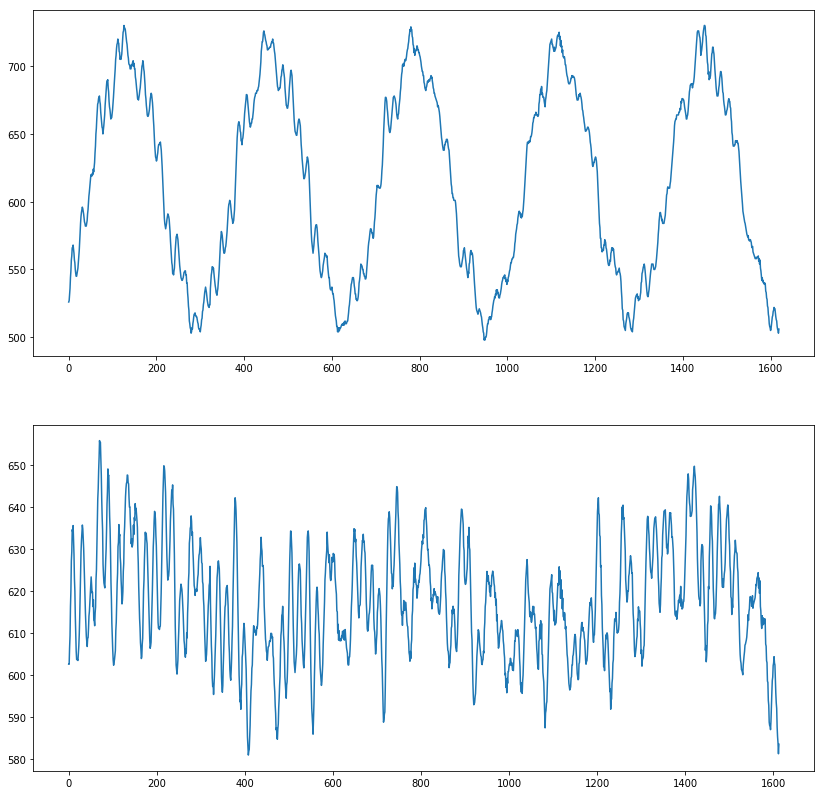

In [132]:
fig, (ax0, ax1) = plt.subplots(2,figsize=(14,14))
ax0.plot(cut)
ax1.plot(mained_signal)
# plt.savefig('a440_mained_experiment.pdf')
# plt.clf()
plt.show()

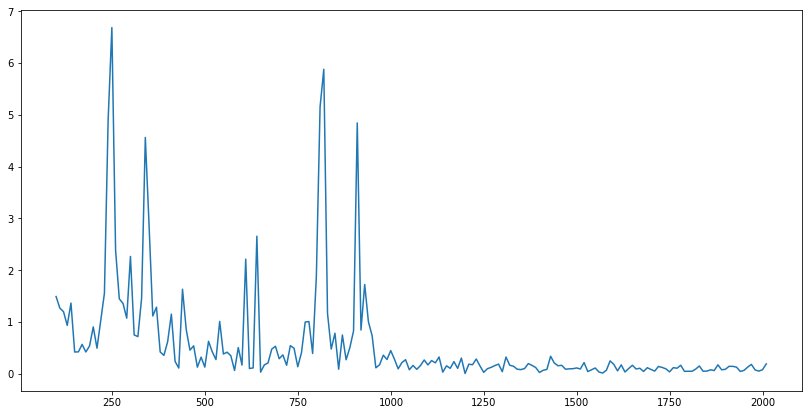

In [138]:
total_frames = len(cut)

t = np.linspace(0,0.1,total_frames)
dt = t[1] - t[0]

yf = np.fft.fft(cut)

nrm_abs_yf = 2/total_frames*np.abs(yf)
freq_scale = np.fft.fftfreq(len(yf),dt)
freq_scale_positive = freq_scale[10:total_frames//8]
freq_prob = nrm_abs_yf[10:total_frames//8]

plt.figure(figsize=(14,7))
plt.plot(freq_scale_positive, freq_prob)
plt.show()
# chop = [94,95,96,97,98,99,100]
# freq_prob = np.delete(freq_prob,chop)
# freq_scale_positive = np.delete(freq_scale_positive,chop)

# plt.figure(figsize=(14,7))
# a,b = 800, 1000
# plt.plot(freq_scale_positive[a:b],freq_prob[a:b])
# plt.show()

In [126]:
filename = 'podo_opera3.csv'
mega = np.genfromtxt(filename,delimiter=',')
long_signal = mega[:,1]
fps = len(mega)/mega[-1,0]

wavfile.write('opera_raw.wav', int(fps), long_signal[1000:])

In [137]:
print(freq_scale_positive[freq_prob > 5])

[249.84567901 809.5        819.49382716]


In [ ]:
plt.figure(figsize=(14,7))
plt.plot(np.fft.fft(long_signal[:10000]))
plt.show()

In [ ]:
infile_name = 'source_a440.wav'
outfile_name = None#'a440_digi.wav'
rate, signal = wavfile.read(infile_name)
# mono np.nonzero(signal[:,0] - signal[:,1])
if len(signal.shape) > 1:
    signal = signal[:,0]

# decrease rate from 44100 to around 16000
audio_expt_rate = int(fps)
if rate > audio_expt_rate + 1000:
    # rate/audio_expt_rate ~= 2.7 
    rate_ratio = rate/audio_expt_rate
    print('rate_ratio:',rate_ratio)
    # sample every rate_ratio values
    those = np.round(rate_ratio*np.arange(len(signal))).astype(int)
    those = those[those < len(signal)]
    sampled_signal = signal[those]
else:
    sampled_signal = signal
    audio_expt_rate = rate

# sampled_signal_n = sampled_signal/absmax(sampled_signal)
# sampled_signal_n -= sampled_signal_n.mean()

# bin signal into channels
intensity_channels = 100
# centre = sampled_signal.mean()
m0, m1 = sampled_signal.min(), sampled_signal.max()
bins = np.linspace(m0-1e-10, m1+1e-10, intensity_channels)
bin_lookup = np.digitize(sampled_signal, bins)
digi_signal = bins[bin_lookup]/m1
# digi_signal = digi_signal/intensity_channels
# digi_signal = (digi_signal-0.5)*2*absmax(sampled_signal)+centre

# data_to_audio = digi_signal

# squeeze = data_to_audio/data_to_audio.max()
# amplitude = np.iinfo(np.int16).max
# scaled_data = amplitude * (squeeze-squeeze.mean())

if outfile_name is None:
    outfile_name = '{}_digi.wav'.format(infile_name[:-4])
wavfile.write(outfile_name, audio_expt_rate, digi_signal)

In [ ]:
rate, signal = wavfile.read('source_feynman(1).wav')
# mono np.nonzero(signal[:,0] - signal[:,1])
signal = signal[:,0]

# decrease rate from 44100 to around 16000
audio_expt_rate = int(fps)
# rate/audio_expt_rate ~= 2.7 
rate_ratio = rate/audio_expt_rate
# sample every rate_ratio values
those = np.round(rate_ratio*np.arange(len(signal))).astype(int)
those = those[those < len(signal)]
sampled_signal = signal[those]

wavfile.write('feynman_sampled.wav', audio_expt_rate, sampled_signal)

In [ ]:
rate, signal = wavfile.read('source_feynman(1).wav')
# mono np.nonzero(signal[:,0] - signal[:,1])
signal = signal[:,0]

amplitude = np.iinfo(np.int16).max
squeeze = signal/absmax(signal)#*amplitude
# scaled_data = amplitude * (squeeze-squeeze.mean())
# shift = signal+signal.mean()/1000

wavfile.write('feynman_direct.wav', rate, squeeze)

In [ ]:
rate, signal = wavfile.read('source_feynman(1).wav')
mono_signal = signal[:,0]
wavfile.write('feynamn_nochanges.wav', rate, mono_signal)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,figsize=(14,14))
# a,b,b1 = 0, int(len(signal)/100), int(len(signal)/40+10000)
a, b = 0, int(len(signal)/50)
ax0.plot(signal[a:b])
ax1.plot(digi_signal[a:b])
plt.savefig('a440_digitised_simulation.pdf')
plt.clf()
# plt.show()

In [ ]:
# # pitch bend by frames, not biggest issue
# audio_sample_rate = int(fps)
# amplitude = np.iinfo(np.int16).max

# data_to_audio = signal#signalm
# out_file_name = 'feynman_test.wav'
# squeeze = data_to_audio/data_to_audio.max()
# scaled_data = amplitude * (squeeze-squeeze.mean())

# wavfile.write(out_file_name, audio_sample_rate, scaled_data)

In [ ]:
# audio_sample_rate = 44100
# # 2**15-1 = 32767, see int16
# amplitude = np.iinfo(np.int16).max
# duration = 1
# t = np.linspace(0, duration, audio_sample_rate)

# freq_inj = 440
# data = amplitude * np.sin(2*np.pi*freq_inj*t)
# write('sine.wav', audio_sample_rate, data)

# # could scale if wanting full dynamic range
# data = amplitude * np.random.uniform(-1, 1, audio_sample_rate)
# write('white_noise.wav', audio_sample_rate, data)

In [ ]:
# # start by finding the signal to be split into bins
# long_signal, fps = series_at_point(filename,return_series=True)

total_frames = len(long_signal)
duration = total_frames/fps

long_timesteps = 500
scanning_range = 10

# q,r = divmod(a,b) s.t. a = q*b+r
bin_frames, bin_remainder = divmod(total_frames,long_timesteps)
# bin_duration = bin_frames/fps
# acts as flag to stop short of the remainder, which is lost
bin_last = total_frames - bin_remainder
# always has long_timesteps number of chunks
bin_signals = [long_signal[i: i+bin_frames] for i in range(0, bin_last, bin_frames)]

# creating the signal grid
# positive side of the fourier spectrum will have half bin_frames
# minus 2 from cutting out the average value, frequency = 0, signal
chop = 100
grid_frames = bin_frames//2-1-chop
grid = np.zeros((grid_frames,long_timesteps))

for i, signal in enumerate(bin_signals):
    # columns are each spectrum, rows are frequency through time
    #col, freq_scale_cut = fourier_spectrum(signal, fps, return_spectrum=True)
    col, freq_scale_cut = fourier_spectrum_2(signal, fps, return_spectrum=True,
                                            remove_mains=True, cutter=1)
    grid[:,i] = col[chop:]

path_grid = viterbi_pathfinder(grid, scanning_range)[1]

ngrid = grid/np.max(grid)

In [ ]:
filename = 'photodiode'
filetag = 'photodiode'

plt.figure(figsize=(7,14))
plt.imshow(ngrid, cmap='viridis');
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')  
# plt.xticks(np.arange(long_timesteps),xtick_labels_1, rotation=90)
# plt.yticks(np.arange(grid_frames),ytick_labels_1)
cbar_fraction = 0.025
cbar = plt.colorbar(fraction=cbar_fraction) 
cbar.set_label('normalised frequency distribution')
plt.title('{}\n fourier spectrum of signal binned over time\n'.format(filename))
plt.ylabel('signal frequency, f / Hz')
plt.xlabel('long time duration, t / s')
plt.savefig('expt_ngrid_{}.pdf'.format(filetag),bbox_inches='tight')
plt.clf()

plt.figure(figsize=(7,14))
plt.imshow(path_grid, cmap='viridis');
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')  
# plt.xticks(np.arange(long_timesteps),xtick_labels_1, rotation=90)
# plt.yticks(np.arange(grid_frames),ytick_labels_1)
plt.title('{}\n viterbi path through signal grid'.format(filename))
plt.ylabel('signal frequency, f / Hz')
plt.xlabel('long time duration, t / s')
plt.savefig('expt_viterbi_path_{}.pdf'.format(filetag),bbox_inches='tight')
plt.clf()